In [1]:
# Import libraries

import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

In [2]:
# Unzip files

local_zip = '../input/dogs-vs-cats-redux-kernels-edition/train.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()

local_zip = '../input/dogs-vs-cats-redux-kernels-edition/test.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [3]:
# Define root directory
root_dir = './new'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

# GRADED FUNCTION: create_train_val_dirs
def create_train_val_dirs(root_path):
  """
  Creates directories for the train and test sets
  
  Args:
    root_path (string) - the base directory path to create subdirectories from
  
  Returns:
    None
  """  

  ### START CODE HERE

  # HINT:
  # Use os.makedirs to create your directories with intermediate subdirectories
  # Don't hardcode the paths. Use os.path.join to append the new directories to the root_path parameter

  os.makedirs(root_dir)
  os.makedirs(os.path.join(root_dir, 'training'))
  os.makedirs(os.path.join(root_dir, 'validation'))
  os.makedirs(os.path.join(root_dir, 'training/cats'))
  os.makedirs(os.path.join(root_dir, 'training/dogs'))
  os.makedirs(os.path.join(root_dir, 'validation/cats'))
  os.makedirs(os.path.join(root_dir, 'validation/dogs'))
  
  ### END CODE HERE

  
try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [4]:
# Test create_train_val_dirs function

for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

./new/validation
./new/training
./new/validation/cats
./new/validation/dogs
./new/training/cats
./new/training/dogs


In [5]:
# GRADED FUNCTION: split_data
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):

  """
  Splits the data into train and test sets
  
  Args:
    SOURCE_DIR (string): directory path containing the images
    TRAINING_DIR (string): directory path to be used for training
    VALIDATION_DIR (string): directory path to be used for validation
    SPLIT_SIZE (float): proportion of the dataset to be used for training
    
  Returns:
    None
  """
  ### START CODE HERE
  source_dir_files_count = len(os.listdir(SOURCE_DIR)) # SOURCE_DIR is /Cat or /Dog with files

  train_files_count = round(source_dir_files_count * SPLIT_SIZE)

  shuffled_list = random.sample(os.listdir(SOURCE_DIR), source_dir_files_count)

  for filename in shuffled_list[:train_files_count]:    
    filesource = os.path.join(SOURCE_DIR, filename)    
    if os.path.getsize(filesource) == 0:
      print("{} is zero length, so ignoring.".format(filename))
    else:
        if "dog" in filename:
            copyfile(filesource, os.path.join(os.path.join(TRAINING_DIR, 'dogs'), filename))
        else:
            copyfile(filesource, os.path.join(os.path.join(TRAINING_DIR, 'cats'), filename))

  for filename in shuffled_list[train_files_count:]: 
    filesource = os.path.join(SOURCE_DIR, filename)    
    if os.path.getsize(filesource) == 0:
      print("{} is zero length, so ignoring.".format(filename))
    else:      
        if "dog" in filename:
            copyfile(filesource, os.path.join(os.path.join(VALIDATION_DIR, 'dogs'), filename))
        else:
            copyfile(filesource, os.path.join(os.path.join(VALIDATION_DIR, 'cats'), filename))

  ### END CODE HERE


In [6]:
# Test your split_data function

# Define paths
SOURCE_DIR = "./train"

TRAINING_DIR = os.path.join(root_dir, "training")
VALIDATION_DIR = os.path.join(root_dir, "validation")

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats")
VALIDATION_CATS_DIR = os.path.join(VALIDATION_DIR, "cats")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs")
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_DIR, "dogs")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_CATS_DIR)) > 0:
  for file in os.scandir(TRAINING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
  for file in os.scandir(TRAINING_DOGS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_CATS_DIR)) > 0:
  for file in os.scandir(VALIDATION_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_DOGS_DIR)) > 0:
  for file in os.scandir(VALIDATION_DOGS_DIR):
    os.remove(file.path)

# Define proportion of images used for training
split_size = .8

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, split_size)

# Training and validation splits
print(f"There are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(VALIDATION_CATS_DIR))} images of cats for validation")
print(f"There are {len(os.listdir(VALIDATION_DOGS_DIR))} images of dogs for validation")

There are 10019 images of cats for training
There are 9981 images of dogs for training
There are 2481 images of cats for validation
There are 2519 images of dogs for validation


In [7]:
# GRADED FUNCTION: train_val_generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  """
  Creates the training and validation data generators
  
  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images
    
  Returns:
    train_generator, validation_generator - tuple containing the generators
  """
  ### START CODE HERE

  # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=20,
                                                      class_mode='binary',
                                                      target_size=(150, 150))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                      batch_size=20,
                                                      class_mode='binary',
                                                      target_size=(150, 150))
  ### END CODE HERE
  return train_generator, validation_generator

In [8]:
# Test your generators
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [9]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop

# GRADED FUNCTION: create_model
def create_model():
  # DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS
  # USE AT LEAST 3 CONVOLUTION LAYERS

  ### START CODE HERE

  model = tf.keras.models.Sequential([ 
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  
  model.compile(optimizer=RMSprop(learning_rate=1e-4),
                loss='binary_crossentropy',
                metrics=['accuracy']) 
    
  ### END CODE HERE

  return model

In [10]:
# Get the untrained model
model = create_model()
model.summary()

2022-08-01 12:12:44.770114: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-01 12:12:44.889822: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-01 12:12:44.890668: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-01 12:12:44.892143: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [11]:
# Train the model
# Note that this may take some time.
history = model.fit(train_generator,
                    epochs=10,
                    verbose=1,
                    validation_data=validation_generator)

2022-08-01 12:12:47.934088: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-08-01 12:12:49.910863: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1000/1000 [==============================] - 203s 195ms/step - loss: 0.6549 - accuracy: 0.5961 - val_loss: 0.6290 - val_accuracy: 0.6290
Epoch 2/10
1000/1000 [==============================] - 185s 185ms/step - loss: 0.5979 - accuracy: 0.6716 - val_loss: 0.6156 - val_accuracy: 0.6414
Epoch 3/10
1000/1000 [==============================] - 190s 190ms/step - loss: 0.5620 - accuracy: 0.7104 - val_loss: 0.5335 - val_accuracy: 0.7336
Epoch 4/10
1000/1000 [==============================] - 191s 192ms/step - loss: 0.5360 - accuracy: 0.7291 - val_loss: 0.5341 - val_accuracy: 0.7314
Epoch 5/10
1000/1000 [==============================] - 189s 189ms/step - loss: 0.5152 - accuracy: 0.7429 - val_loss: 0.4852 - val_accuracy: 0.7650
Epoch 6/10
1000/1000 [==============================] - 185s 185ms/step - loss: 0.4936 - accuracy: 0.7606 - val_loss: 0.4897 - val_accuracy: 0.7666
Epoch 7/10
1000/1000 [==============================] - 196s 196ms/step - loss: 0.4775 - accuracy: 0.7700 - val_loss: 0.457

In [12]:
# Download tpre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-08-01 12:44:37--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.12.128, 172.253.123.128, 173.194.216.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  60.7MB/s    in 1.4s    

2022-08-01 12:44:39 (60.7 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [13]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

In [14]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [15]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [16]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

# Append the dense network to the base model
model = Model(pre_trained_model.input, x) 

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [17]:
# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [18]:
# Train the model (now with TL applied)
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 28s - loss: 0.3265 - accuracy: 0.8610 - val_loss: 0.1958 - val_accuracy: 0.9140
Epoch 2/20
100/100 - 25s - loss: 0.2405 - accuracy: 0.9130 - val_loss: 0.2214 - val_accuracy: 0.9190
Epoch 3/20
100/100 - 23s - loss: 0.2421 - accuracy: 0.9005 - val_loss: 0.1986 - val_accuracy: 0.9240
Epoch 4/20
100/100 - 23s - loss: 0.1977 - accuracy: 0.9290 - val_loss: 0.1973 - val_accuracy: 0.9310
Epoch 5/20
100/100 - 24s - loss: 0.2207 - accuracy: 0.9185 - val_loss: 0.2322 - val_accuracy: 0.9130
Epoch 6/20
100/100 - 24s - loss: 0.2263 - accuracy: 0.9210 - val_loss: 0.1830 - val_accuracy: 0.9290
Epoch 7/20
100/100 - 26s - loss: 0.1837 - accuracy: 0.9370 - val_loss: 0.1374 - val_accuracy: 0.9380
Epoch 8/20
100/100 - 24s - loss: 0.1964 - accuracy: 0.9315 - val_loss: 0.2949 - val_accuracy: 0.8940
Epoch 9/20
100/100 - 24s - loss: 0.1829 - accuracy: 0.9320 - val_loss: 0.3378 - val_accuracy: 0.8980
Epoch 10/20
100/100 - 23s - loss: 0.2190 - accuracy: 0.9250 - val_loss: 0.1656 - val_accura

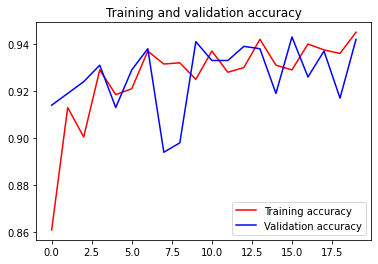

<Figure size 432x288 with 0 Axes>

In [19]:
# Evaluate the results
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()